In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from plotting import formatmpl
from hybrid_mdmc.interactions import *
from hybrid_mdmc.system import *
from hybrid_mdmc.calculate_diffusion import *
from hybrid_mdmc.voxels import *
from hybrid_mdmc.filehandlers import parse_diffusion_file

In [2]:
def load_summary_system_state(filename):
    data = np.loadtxt(filename, comments="#")
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#"):
                header = line.split()[1:]
                break
    return pd.DataFrame(data, columns=header)


def solve_ODE(t_span, y0, k, t_eval=None, diffcoeff=np.inf, raa=3.4e-10):
    def dAdt(time, y, k, diffcoeff, raa):
        A = y[0]
        A2 = y[1]
        k1 = k[0]
        if diffcoeff != np.inf:
            kd = 4*np.pi*6.022e23*diffcoeff*raa
            k1 = kd*k[0]/(kd+k[0])
        k2 = k[1]
        rate1 = k1*A*(A-1)/2
        #rate1 = k1*A*A
        rate2 = k2*A2
        return [-2*rate1 + 2*rate2, rate1 - rate2]
    result = solve_ivp(dAdt, t_span, y0, t_eval=t_eval, args=(k,diffcoeff,raa))
    return result.t, result.y[0], result.y[1]


In [7]:
class KMCMD_Result:

    def __init__(
            self,
            system: str,
            prefixes: list,
            gamma: float = 0.0,
            m: float = 16.0/6.022e23/1e3, # kg
            s: float = 3.4*1e-10, # m
            e: float = 0.29500339*4184/6.022e23, # J
            lammps_stepsize: float = 0.001, # s
            plot_name: str = '',
            color: str = '#000000',
            ):
        self.system = system
        self.prefixes = prefixes
        self.gamma = gamma
        self.m = m
        self.s = s
        self.e = e
        self.lammps_stepsize = lammps_stepsize
        self.plot_name = plot_name
        self.color = color
        self.system_data = None
        self.system_state_summaries = None
        self.Langevin_diffusion_coefficient = None
        self.direct_transtion_rates = None

        return

    def load_system_data(self):
        self.system_data = SystemData(self.system, None)
        self.system_data.read_json()
        return
    
    def load_system_state_summaries(self):
        self.system_state_summaries = {}
        for pre in self.prefixes:
            self.system_state_summaries[pre] = load_summary_system_state(f"{pre}.summary.txt")
        return
    
    def load_direct_transtion_rates(self):
        self.direct_transtion_rates = {}
        for pre in self.prefixes:
            self.direct_transtion_rates[pre] = read_direct_transition_rates_file(f"{pre}.direct_transition_rates.txt")
        return
    
    def load_diffusion_rates(self):
        self.diffusion_rates = {}
        for pre in self.prefixes:
            self.diffusion_rates[pre] = parse_diffusion_file(f"{pre}.diffusion.txt")
        return
    
    def calculate_Langevin_diffusion_coefficient(self):
        self.Langevin_diffusion_coefficient = 0.852*self.gamma*self.s*np.sqrt(self.e/self.m)
        return
    

In [ ]:
colors_list = [
    "#D3582C", # Savoie orange
    "#5FC89F", # Savoie green
    "#2656B8", # Savoie blue
    "#f18d93", # pink
    "#e7b10a", # yellow
    "#bf4288", # magenta
    "#c0A8cb", # violet
    "#3e9e9a", # greenish blue
    "#beb837", # green
    "#ac3535", # red
    
    ]

results_list = [
    KMCMD_Result("kmctoy", ["kmctoy"], color="#f18d93"),
    ]

for result in results_list:
    result.load_system_data()
    for reaction in result.system_data.reactions:
        reaction.calculate_raw_rate(result.system_data.hkmcmd["temperature_rxn"])
    result.load_system_state_summaries()

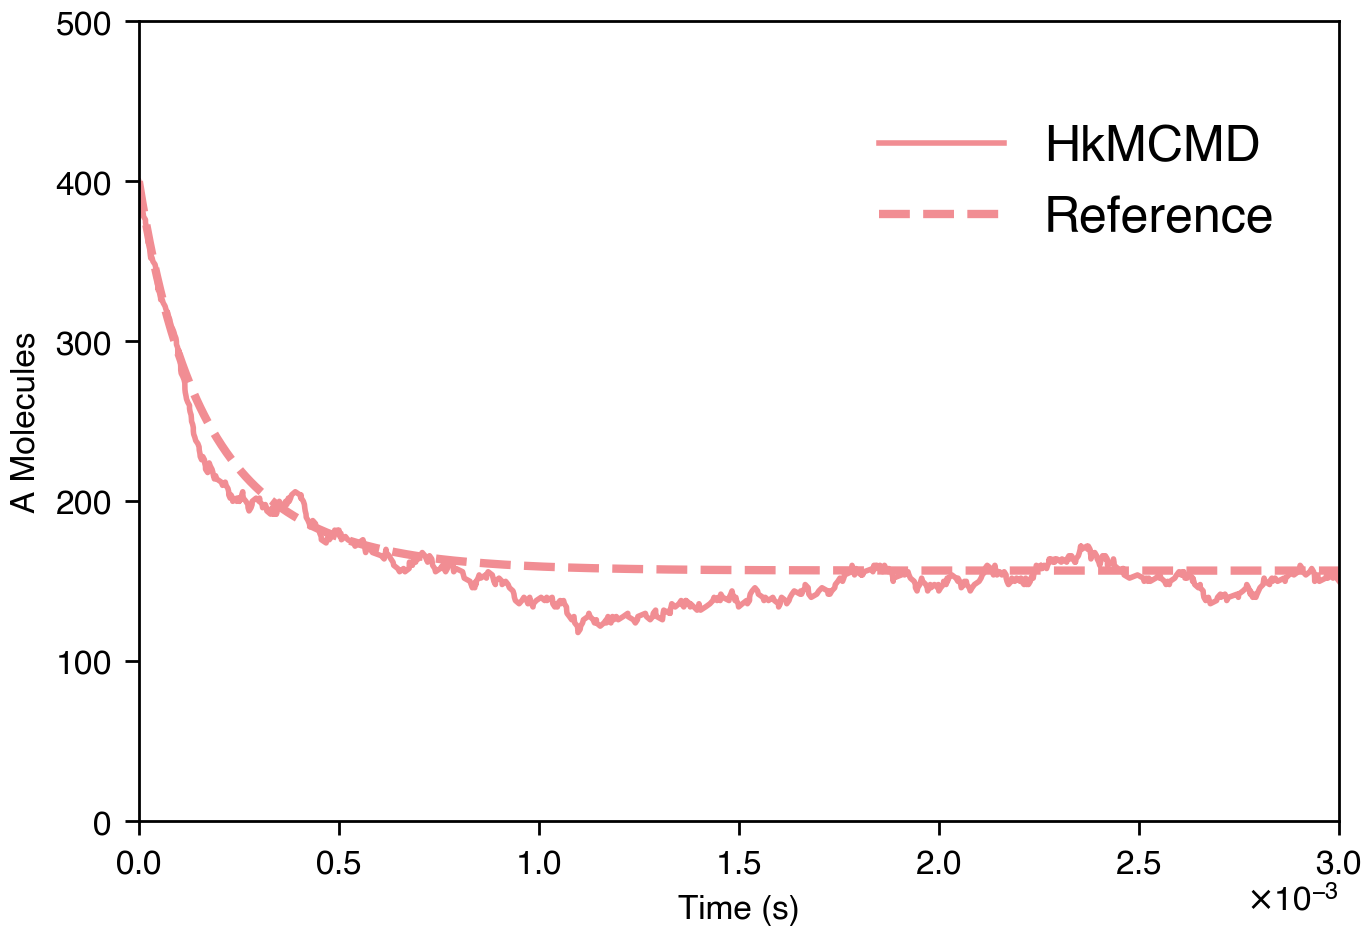

In [17]:
fig, ax, legendprop = formatmpl()
for result in results_list:

    # Plot HKMCMD results
    for pre in result.prefixes:
        ax.plot(
            result.system_state_summaries[pre].loc[:,"time"],
            result.system_state_summaries[pre].loc[:,"A"],
            color=result.color, linewidth=4, linestyle="-", label="HkMCMD")

    # Plot reference
    t_span = [0, 3e-3]
    y0 = [400, 0]
    k = [reaction.rawrate for reaction in result.system_data.reactions]
    t_eval = np.linspace(t_span[0], t_span[-1], 1000)
    raa = 3.4e-10
    reference_time, reference_A, reference_A2 = solve_ODE(
        t_span, y0, k, t_eval, np.inf, raa
    )
    ax.plot(
        reference_time,
        reference_A,
        color=result.color,
        alpha=1.0,
        linewidth=6,
        linestyle="--",
        label="Reference"
    )

# Legend, format, and save
legendprop["loc"] = (0.6, 0.7)
ax.legend(**legendprop)
ax.set_xlim(0,t_span[1])
ax.set_ylim(0, 500)
ax.set_ylabel("A Molecules")
ax.set_xlabel("Time (s)")
fig.savefig("kmctoy_reference.pdf", bbox_inches="tight")